In [3]:
# Read the dataset

test_set_path = r"data\bigdatasets\mnist\mnist_test.csv"
train_set_path = r"data\bigdatasets\mnist\mnist_train.csv"

import csv
import torch
import torch.nn.functional as F


def read_csv(path: str, read_rows: int = None):
    # Reads the csv and returns a list of lists
    # The first row is the header and is ignored
    # The csv contains 29 columns the first one is the label and the rest are the pixels

    xs, ys = [], []
    with open(path, "r") as f:
        reader = csv.reader(f, delimiter=",")
        next(reader) # skip the header
        for row in reader:
            ys.append(int(row[0]))
            xs.append([float(x) for x in row[1:]])

            if read_rows is not None and len(xs) >= read_rows:
                break
            
    xs = torch.tensor(xs, dtype=torch.float32)
    ys =  F.one_hot(torch.tensor(ys), num_classes=10)

    return xs.view((-1,28,28)), ys.float()


train_xs, train_ys = read_csv(train_set_path)
test_xs, test_ys = read_csv(test_set_path)

train_xs.shape, train_ys.shape, test_xs.shape, test_ys.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000, 10]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000, 10]))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])


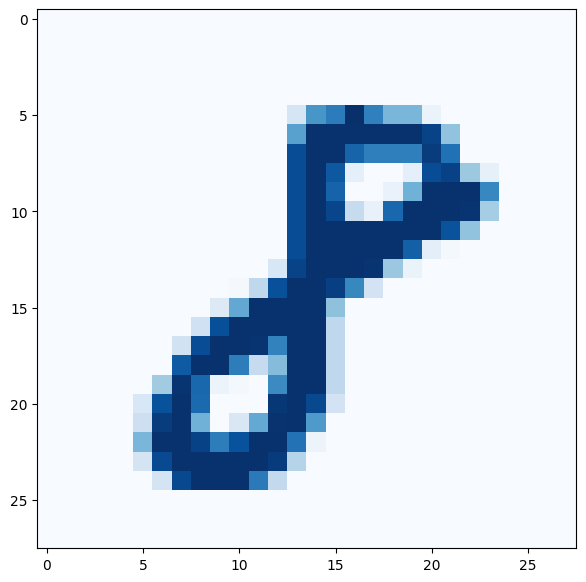

In [4]:
# Visualize the dataset
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(7,7))

print(train_ys[31])
plt.imshow(train_xs[31], cmap='Blues')


In [72]:
# Build the training harness
from custom_torch.nn import *
from enum import Enum


class Trainer:

    class Mode(Enum):
        TRAIN = 1
        FIND_LR = 2


    def __init__(self, model: Module, xs: torch.Tensor, ys: torch.Tensor, loss_fn, batch_size=32):
        self.__learning_rate = 0.01
        self.model = model
        self.xs = xs
        self.ys = ys
        self.loss_fn = loss_fn
        self.batch_size = batch_size

        # Tracking
        self.losses = []


    @property
    def learning_rate(self):
        if len(self.losses) > 100_000:
            return 0.001
        
        return self.__learning_rate

    def train(self):
        batch_idx = torch.randint(0,self.xs.shape[0], (self.batch_size,))

        x = self.xs[batch_idx]
        y = self.ys[batch_idx]

        logits = self.model(x.view((-1, 28*28))
        loss = self.loss_fn(logits, y)

        for param in self.model.parameters:
            param.grad = None

        loss.backward()

        for param in self.model.parameters:
            param.data -= self.learning_rate * param.grad


        return loss.item()
    
    def run(self, epoch = 10_000):
        for i in range(epoch):
            loss = self.train()
            if i % 10_000 == 0:
                print(f"Epoch {i} loss: {loss}")

            self.losses.append(loss)


        



SyntaxError: '(' was never closed (<ipython-input-72-9915fa42ba20>, line 38)

# MLP model
- Architecture
  - 784 input neurons
  - 64 hidden neurons
  - 64 hidden neurons
  - Softmax output layer with 10 neurons

In [6]:
# Build the model

n_hidden_1 = 64
n_hidden_2 = 64


model = Sequential(
    FlattenConsecutive(28),
    Linear(28*28, n_hidden_1), Tanh(), #BatchNorm(n_hidden_1),
    Linear(n_hidden_1, n_hidden_2), Tanh(), #BatchNorm(n_hidden_2),
    Linear(n_hidden_2, 10)
)

for p in model.parameters:
    p.requires_grad = True
    print(p.shape)

print("Total parameters:", sum(p.numel() for p in model.parameters))

trainer = Trainer(model, train_xs, train_ys, F.cross_entropy , batch_size=256)


torch.Size([784, 64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([10])
Total parameters: 55050


In [7]:

trainer.run(epoch=50_000)

Epoch 0 loss: 2.396819591522217
Epoch 10000 loss: 0.15802393853664398
Epoch 20000 loss: 0.09446746110916138
Epoch 30000 loss: 0.1554972529411316
Epoch 40000 loss: 0.08348728716373444


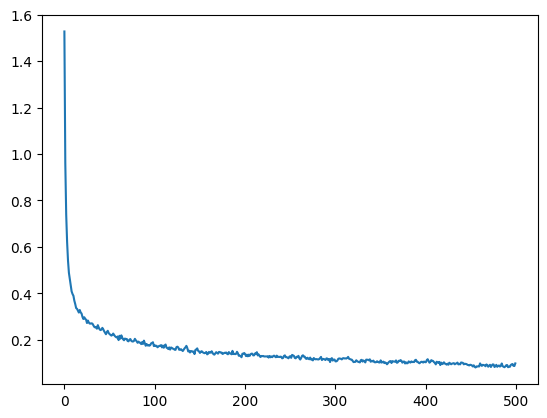

In [8]:
plt.plot(torch.tensor(trainer.losses).view(-1,100).mean(dim=1))

In [9]:
# Test the model

@torch.no_grad()
def test(model, xs, ys):
    logits = model(xs)
    loss = F.cross_entropy(logits, ys)

    preds = torch.argmax(logits, dim=1)
    labels = torch.argmax(ys, dim=1)

    accuracy = (preds == labels).float().mean()
    print(f"Accuracy: {accuracy.item()}")
    print(f"Loss: {loss.item()}")



test(model, train_xs, train_ys)
test(model, test_xs, test_ys)



Accuracy: 0.9721666574478149
Loss: 0.08735964447259903
Accuracy: 0.9605000019073486
Loss: 0.13327090442180634


In [10]:
@torch.no_grad()
def predict(model, xs, ys):
    logits = model(xs.view((1,28,28)))
    preds = torch.argmax(logits, dim=1)
    label = torch.argmax(ys).item()

    # print(f"Prediction:{preds.item()}, Label:{label}")
    return preds.item() == label


success = 0
for x, y in zip(test_xs, test_ys):
    if predict(model, x, y):
        success += 1

print(f"Success rate: {success / len(test_xs)}")
    

Success rate: 0.9605


# Accuracy of models
- MLP: 96.45%

# CNN model

### Todo
- [ ] Implement CNN layer
- [ ] Implement Max Pooling layer
- [ ] Train the model

In [94]:
class Conv(Module):
    def __init__(self, input_shape: tuple, kernel_size : int, depth: int):
        """
        depth: number of filters
        input_shape: (depth, height, width)

        """

        input_depth, input_height, input_width = input_shape 

        self.depth = depth
        self.input_depth = input_depth
        self.input_shape = input_shape

        self.output_shape = (depth, input_height - kernel_size +1 , input_width - kernel_size +1)
        self.kernal_shape = (depth, input_depth, kernel_size, kernel_size)

        self.kernals = torch.randn(self.kernal_shape)
        self.bias = torch.randn(self.output_shape)
        

    def __call__(self, x):
        out = self.bias
        for i in range(self.depth):
            for j in range(self.input_depth):
                out[i] += F.conv2d(x[j], self.kernals[i][j], padding=0)

        # x.shape = (batch, in_channels, height, width)
        # self.weights.shape = (out_channels, in_channels, kernel_size, kernel_size)
        # self.bias.shape = (out_channels)

        # out.shape = (batch, out_channels, height, width)

        # out = F.conv2d(x, self.weights, self.bias, self.stride, self.padding)
        # return out

        # return F.conv2d(x, self.weights, self.bias, self.stride, self.padding)
    
    @property
    def parameters(self):
        return [self.kernals, self.bias]
    

class MaxPool2d(Module):
    def __init__(self, kernel_size, stride=1, padding=1):
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def __call__(self, x):
        return F.max_pool2d(x, self.kernel_size, self.stride, self.padding)
    
    @property
    def parameters(self):
        return []
    

class ReLu(Module):
    def __call__(self, x):
        return F.relu(x)
    
    @property
    def parameters(self):
        return []
    
class Flatten(Module):
    def __call__(self, x):
        return x.flatten(start_dim=1)
    
    @property
    def parameters(self):
        return []
    


In [95]:
model = Sequential(
    Conv((1,28,28), 3, 3),
)


for p in model.parameters:
    p.requires_grad = True
    print(p.shape)

print("Total parameters:", sum(p.numel() for p in model.parameters))

torch.Size([3, 1, 3, 3])
torch.Size([3, 26, 26])
Total parameters: 2055


In [97]:
    
batch_size = 256
learning_rate = 0.001
losses = []

# for i in range(10):

batch_idx = torch.randint(0,train_xs.shape[0], (batch_size,))

x = train_xs[batch_idx]
y = train_ys[batch_idx]

# x.shape
model(torch.randn(1,1,28,28))
# logits = model(x.view((1,1,28,28)))
# loss = F.cross_entropy(logits, y)

# for param in model.parameters:
#     param.grad = None

# loss.backward()

# for param in model.parameters:
#     param.data -= learning_rate * param.grad


# losses.append(loss.item())
# if i % 1000 == 0:
#     print(f"Epoch {i} loss: {loss.item()}")


RuntimeError: weight should have at least three dimensions